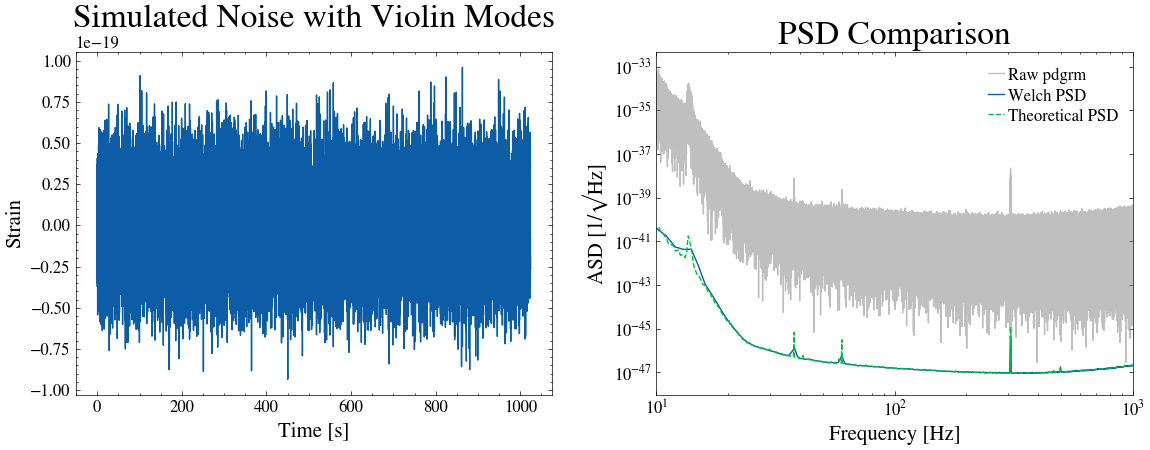

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# PyCBC imports
from pycbc.types import FrequencySeries
from pycbc.noise import noise_from_psd

# 1. Load Bilby ASD file (frequency, ASD)
freqs_bilby, asd_bilby = np.loadtxt("https://raw.githubusercontent.com/bilby-dev/bilby/main/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt", unpack=True)


# 2. Convert ASD to PSD and interpolate
psd_bilby = asd_bilby**2
fs = 4096.0
duration = 1024.0
n_samples = int(fs * duration)
delta_t = 1.0 / fs
delta_f = 1.0 / duration
freqs_sim = np.fft.rfftfreq(n_samples, delta_t)

interp_psd = interp1d(
    freqs_bilby, psd_bilby,
    kind='linear', bounds_error=False,
    fill_value=(psd_bilby[0], psd_bilby[-1])
)
psd_sim = interp_psd(freqs_sim)

# 3. Wrap numpy PSD array into a PyCBC FrequencySeries
psd_fs = FrequencySeries(psd_sim, delta_f=delta_f)

# 4. Generate noise
seed = 42
noise_ts = noise_from_psd(n_samples, delta_t, psd_fs, seed=seed)
noise_2ts = noise_from_psd(n_samples, delta_t, psd_fs, seed=0)

# 5. Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(noise_ts.sample_times, noise_ts)
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.title('Simulated Noise with Violin Modes')

plt.subplot(1, 2, 2)
from scipy.signal import welch
f, Pxx = welch(noise_ts, fs=fs, nperseg=fs)
# periodogram of raw data

pdgrm = np.abs(np.fft.rfft(noise_ts))**2/fs
freqs = np.fft.rfftfreq(len(noise_ts), delta_t)
plt.loglog(freqs, pdgrm, label='Raw pdgrm', alpha=0.5, color='gray')
plt.loglog(f, Pxx, label='Welch PSD')
plt.loglog(freqs_bilby, psd_bilby, '--', label='Theoretical PSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [1/√Hz]')
plt.legend()
plt.xlim(10, 1000)
plt.title('PSD Comparison')

plt.tight_layout()
plt.show()


In [ ]:
from sgvb_psd.psd_estimator import PSDEstimator


data = np.array([noise_ts.numpy(), noise_2ts.numpy()])[..., 0:16384]

psd_estim = PSDEstimator(
    data,
    fs=fs, 
    nchunks=4
)

In [21]:
len(noise_2ts.numpy())

4194304

In [30]:
2 ** 14 // 4

4096